# Video motion estimation for surface crack inspection with restricted camera movement (only horizontal and vertical translation)

This notebook describes the implementation of a video motion estimation component as described in [1].
It takes as input two frames (as OpenCV numpy arrays) and returns the displacement vector (x,y) in pixels.

See <a href="https://www.youtube.com/watch?v=NprGGjB0v1M">example video</a>.

## Limitations

- It has only been tested with a computer generated video that performs a trajectory over a high resolution image. Results may be different if there is a minimal rotation or the input video has more noise.

## References

1. <cite data-cite="tie-2764844-pp">NB-CNN: Deep Learning-Based Crack Detection Using Convolutional Neural Network and Naïve Bayes Data Fusion</cite>
2. [OpenCV Tutorial - Template Matching](https://docs.opencv.org/3.4.3/de/da9/tutorial_template_matching.html)

## Base implementation

In [30]:
from abc import ABC, abstractmethod
import numpy as np
import cv2
import os
import sys

class VideoMotionEstimationStrategy(ABC):
    
    @abstractmethod
    def calculate_motion(frame1, frame2):
        pass
    
class VideoMotionEstimator():
    def __init__(self, strategy: VideoMotionEstimationStrategy) -> None:
        self._strategy = strategy
        
    def calculate_motion(self,frame1,frame2):
        return self._strategy.calculate_motion(frame1,frame2)

## Phase correlation strategy

See: https://en.wikipedia.org/wiki/Phase_correlation.

In [31]:
class PhaseCorrelationStrategy(VideoMotionEstimationStrategy):
            
    def calculate_motion(frame1, frame2):
        dx = np.zeros(2)
        frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
        frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)
        g_a = np.fft.fft2(frame1_gray)
        g_b = np.fft.fft2(frame2_gray)
        conj_b = np.ma.conjugate(g_b)
        r = g_a*conj_b
        r /= np.absolute(r)
        r = np.fft.ifft2(r)
        d = np.unravel_index(np.argmax(r), r.shape)        
        w = frame1.shape[0]
        h = frame1.shape[1]
        # FIXME: adjust orientation
        if d[1] > (h/2):
            dx[1] = d[1] - h
        else:
            dx[1] = d[1]           
        if d[0] > (w/2):
            dx[0] = d[0] - w
        else:
            dx[0] = d[0]        
        return dx 

## OpenCV block matching strategy

In [32]:
class OpenCVBlockMatchingStrategy(VideoMotionEstimationStrategy):    
        
    def calculate_motion(frame1, frame2):
        dx = np.zeros(2)
        
        x0= np.array([40,60])
        
        h_margin=x0[0]
        w_margin=x0[1]
        height=frame1.shape[0]
        width=frame1.shape[1]
        
        result = cv2.matchTemplate(
            frame2, 
            frame1[h_margin:(height-h_margin),w_margin:(width-w_margin)],
            cv2.TM_SQDIFF
        )
        
        cv2.normalize( result, result, 0, 1, cv2.NORM_MINMAX, -1 )
        
        _minVal, _maxVal, minLoc, maxLoc = cv2.minMaxLoc(result, None)
        matchLoc = minLoc        
        dx[0] = x0[0] - matchLoc[1]
        dx[1] = x0[1] - matchLoc[0]        
        return dx

## Optical flow strategy

In [33]:
#WIP
class OpticalFlowStrategy(VideoMotionEstimationStrategy):
        
    def optical_flow(frame1, frame2,hsv): 
        flow = cv2.calcOpticalFlowFarneback(
                frame1,
                frame2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        return rgb
    
    
    def calculate_motion(frame1, frame2):
        frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
        frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)
        flow = cv2.calcOpticalFlowFarneback(frame1_gray,frame2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        return flow

## Definition of test procedure

In [34]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 5

# Test definition
INPUT_VIDEO="../../../data/footage/wall-scan.avi"
ORIGINAL_IMAGE="../../../data/media/nasa-antartica.jpg"


def plot_trajectory(traj):        
    x = traj[:,1].T
    y = traj[:,0].T

    plt.subplot(1, 2, 1)
    im = plt.imread(ORIGINAL_IMAGE)
    plt.imshow(im,interpolation="nearest",aspect="auto")
    plt.scatter(x,y,s=0.6)
    plt.grid()
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    plt.title("Trajectory over original image")
        
    plt.subplot(1, 2, 2)
    plt.plot(x)
    plt.plot(y)
    plt.xlabel('frame #', fontsize=16)
    plt.ylabel('offset in pixels', fontsize=16)
    plt.legend(('x','y'))
    
    plt.tight_layout()
    plt.show()
    
    return

def test_video_motion_estimation(motion_estimator):    
    cap =  cv2.VideoCapture(INPUT_VIDEO)  

    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)

    ret, frame1 = cap.read()

    if ret == False:
        print("read failed")
        return
    
    x0 = int((width/2) - 50)
    x1 = int((width/2) + 50)
    y0 = int((height/2) - 50)
    y1 = int((height/2) + 50)

    traj = np.zeros((1,2,length)) # 1, (x,y), 3 timesteps
    for i in range(1,length):
        ret, frame2 = cap.read()
        if ret == False:
            break
        v = motion_estimator.calculate_motion(frame1, frame2)        
        #print(v)
        traj[0,:,i]=traj[0,:,i-1]+v
        frame1 = frame2
    cap.release()    
    return traj

## Phase correlation strategy test

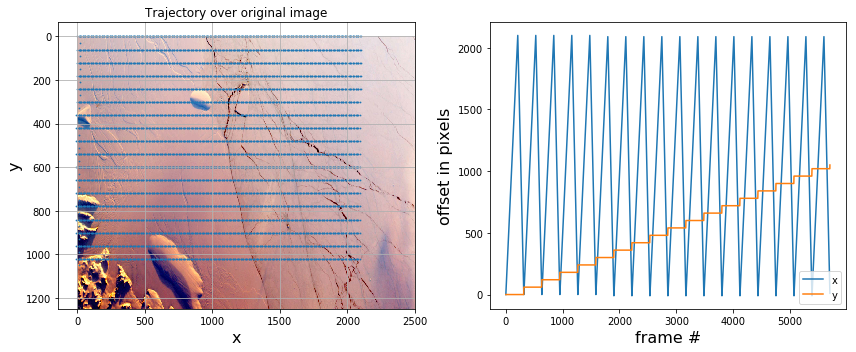

In [35]:
traj = test_video_motion_estimation(VideoMotionEstimator(PhaseCorrelationStrategy))
plot_trajectory(traj)

## OpenCV block matching strategy test

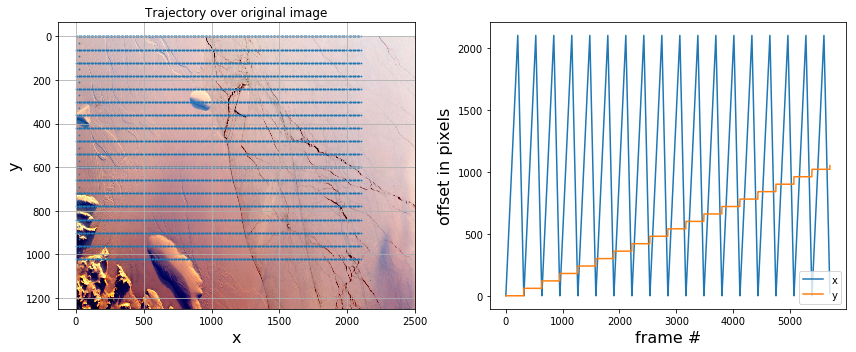

In [36]:
traj = test_video_motion_estimation(VideoMotionEstimator(OpenCVBlockMatchingStrategy))
plot_trajectory(traj)

## Optical flow strategy test

WIP